In [9]:
# https://stats.stackexchange.com/questions/299688/logistic-regression-adaboost
# https://towardsdatascience.com/boosting-algorithm-adaboost-b6737a9ee60c
from sklearn.datasets import make_classification

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
# from logistic import Logistic_Regression
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy
# X, y = make_classification(n_samples=500, n_features=5, n_informative=3, n_classes=2, flip_y=0.4, random_state=42)
# data = np.c_[X, y.ravel()]
# data = pd.DataFrame(data, columns=["f1", "f2", "f3", "f4", "f5", "output"])
# data.head()

# X = data[data.columns[:-1]].values
# y = data[data.columns[-1]].values

# x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=47)
# len(x_train), len(x_val), len(y_train), len(y_val)

# np.save("x_train", x_train)
# np.save("y_train", y_train)
# np.save("x_val", x_val)
# np.save("y_val", y_val)

# x_train = np.load("x_train.npy")
# y_train = np.load("y_train.npy")
# x_val = np.load("x_val.npy")
# y_val = np.load("y_val.npy")

from sklearn.base import BaseEstimator


class Logistic_Regression(BaseEstimator):
    
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.cost_per_iteration = []
        
    
    def _sigmoid(self, x):
        EPS = 1e-7
        return 1 / (1 + np.exp(-x + EPS))
    
    
    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0
        
        # gradient descent

        for _ in range(self.epochs):
            # forward propagation
            Z = np.dot(X, self.weights) + self.bias
            A = self._sigmoid(Z)
            
            # backward propagation
            dw = (1 / m) * np.dot(X.T, A - y)
            db = (1 / m) * np.sum(A - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
    def predict(self, X):
        Z = np.dot(X, self.weights) + self.bias
        A = self._sigmoid(Z)
    
        if not isinstance(A, float):
            y_predicted_cls = [1 if i >= 0.5 else 0 for i in A]
        else:
            y_predicted_cls = 1 if A >= 0.5 else 0
        return y_predicted_cls
    
    
    def __str__(self):
        return f"Logistic_Regression(learning_rate={self.learning_rate}, epochs={self.epochs})"
class AdaBoost(object):
    
    def __init__(self, base_estimator, n_estimators, learning_rate):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.predictor_weightages = []
        
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        for i in range(self.n_estimators):

            # initially all instances have the same weight
            instance_weights = self._initial_instance_weights(n_samples)
            
            # Use predictor to make classification error
            clone_clf = clone(self.base_estimator)
            clone_clf.fit(X, y)
            predicted = clone_clf.predict(X)
            
            # getting misclassified instances
            mis_classified_instances, acc = self._getAccuracy(y, predicted)
            
            # total error made by the predictor
            total_err = self._total_error(mis_classified_instances, instance_weights)
            
            # weightage of predictor based on its error
            predictor_weightage = self._get_predictor_weightage(total_err)
            self.predictor_weightages.append((i, clone_clf, predictor_weightage))
            
            # updating instance weights
            instance_weights = self._update_instance_weights(mis_classified_instances, 
                                                             instance_weights, predictor_weightage)

            
            # sampling data with replacement focusing on instances that were misclassified
            X, y = self._new_sample_set(X, y, instance_weights)

    

    def _initial_instance_weights(self, shape):
        instance_weights = np.full(shape=shape, fill_value=1/shape)
        return instance_weights
    
    
    def _getAccuracy(self, true, predicted):
        assert len(true) == len(predicted)
        error_instance = np.equal(true, predicted).astype(int)
        miss_classified = []

        for i, j in enumerate(error_instance):
            if j == 0:
                miss_classified.append(i)
                
        accuracy = np.sum(true == predicted)
        return miss_classified, (accuracy/len(true)) * 100.0
    
    
    def _total_error(self, mis_classified, instance_weights):
        error = 0
        for i in mis_classified:
            error += instance_weights[i]

        return error
    
    def _get_predictor_weightage(self, error):
        EPS = 1e-5
        weightage = 0.5 * np.log((1.0 - error + EPS) / (error + EPS))
        return weightage

    
    def _update_instance_weights(self, mis_classified_instances, instance_weights, predictor_weightage):
        weights = instance_weights[:]
        EPS = 1e-10
        for idx in range(len(instance_weights)):
            if idx in mis_classified_instances:
                weights[idx] = weights[idx] * np.exp(predictor_weightage + EPS)
            else:
                weights[idx] = weights[idx] * np.exp(-predictor_weightage + EPS)


        # Normalizing weights
        summed_weights = np.sum(weights)
        weights /= summed_weights
        return np.array(weights)
    
    def _new_sample_set(self, X, y, instance_weights):
        intervals = []
        intervals.append(instance_weights[0])

        for i, j in enumerate(instance_weights[1:], 1):
            intervals.append(j + intervals[i-1])

        idxs = []

        for i in range(X.shape[0]):
            samp = np.random.sample()
            try:
                idx = np.searchsorted(intervals, samp, side='right')
                _ = X[idx] # check if exists
            except:
                idx = idx - 1

            finally:
                idxs.append(idx)

        X = X[idxs]
        y = y[idxs]
        return X, y
    
    def predict(self, X):
        clf_predictions = np.array([clf.predict(X) for idx, clf, weightage in self.predictor_weightages])
        predictions = []
        
        for sample_predictions in clf_predictions.T:
            class_0 = 0
            class_1 = 0
            
            for predictor, predictor_op in enumerate(sample_predictions):
                if predictor_op == 0:
                    class_0 += self.predictor_weightages[predictor][2]
                else:
                    class_1 += self.predictor_weightages[predictor][2]
            
            if class_0 > class_1:
                predictions.append(0)
            else:
                predictions.append(1)
        
        return np.array(predictions)
    
diabetes_data = pd.read_csv(r'C:\Users\mahal\OneDrive\Desktop\Py_programs\githubeg\diabetes_data.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [12]:
X = diabetes_data[diabetes_data.columns[:-1]].values
y = diabetes_data[diabetes_data.columns[-1]].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
ada_clf = AdaBoost(base_estimator=Logistic_Regression(learning_rate=0.001, epochs=500),
                  n_estimators=10, learning_rate=0.5)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_train)
print(f"Training Accuracy: {round(accuracy(y_train, y_pred), 2)}")

y_pred = ada_clf.predict(X_test)
print(f"Validation Accuracy: {round(accuracy(y_test, y_pred), 2)}")

from sklearn.metrics import precision_score, recall_score, f1_score
print(f"Model Precision: {precision_score(y_test, y_pred)}")
print(f"Model Recall: {recall_score(y_test, y_pred)}")
print(f"Model F1-score: {f1_score(y_test, y_pred)}")


Training Accuracy: 0.63
Validation Accuracy: 0.62
Model Precision: 0.4583333333333333
Model Recall: 0.4074074074074074
Model F1-score: 0.4313725490196078


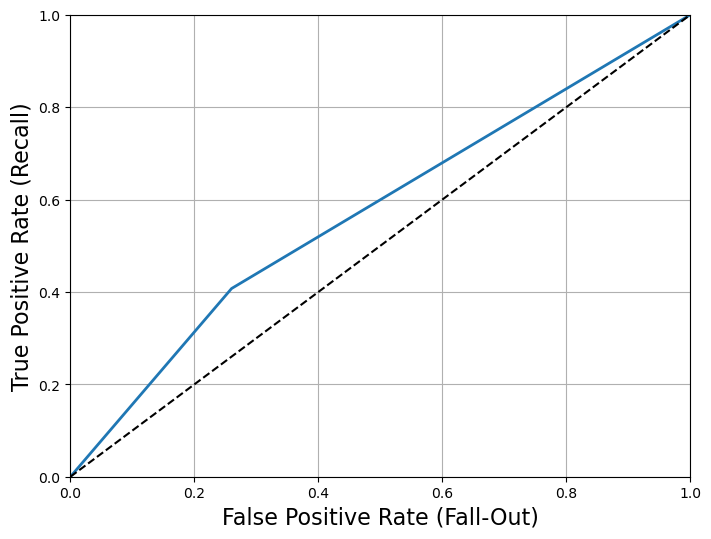

In [13]:
# roc curve 
from sklearn.metrics import roc_curve

fpr, tpr, thresholdsh = roc_curve(y_test, y_pred)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

In [14]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred)

0.5737037037037037